In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='paper', style='darkgrid', palette='pastel')

# import local libraries
from environments.linear import Linear_SDI
from environments.orbit import Orbital_SDI
from environments.box import Box_SDI

from src.OptimalControl.LQR import LQRSolver
from src.OptimalControl.KalmanFilter import KalmanFilter
from src.OptimalControl.LQG import LQGSolver

In [2]:
def run_LQR(env, controller, T=20, dt=.1, x0=None):
    time_space = np.arange(0, T, dt)
    X = np.zeros((len(time_space)+1, env.dim))
    Y = np.zeros((len(time_space)+1, env.dim))
    U = np.zeros((len(time_space), env.dim))
    R = np.zeros((len(time_space), env.dim))

    y = env.reset(x0=x0)

    X[0] = env.state
    Y[0] = y

    for it, t, in enumerate(time_space):
        u = controller(env.state)
        y, rew, done, _ = env.step(u)

        X[it+1] = env.state
        Y[it+1] = y
        U[it] = u
        R[it] = rew
    
    return X, Y, U, R

def run_LQG(env, controller, T=20, dt=.1, x0=None):
    time_space = np.arange(0, T, dt)
    X = np.zeros((len(time_space)+1, env.dim))
    Y = np.zeros((len(time_space)+1, env.dim))
    U = np.zeros((len(time_space), env.dim))
    R = np.zeros((len(time_space), env.dim))

    y = env.reset(x0=x0)
    controller.x_est = y
    u = None

    X[0] = env.state
    Y[0] = y

    for it, t, in enumerate(time_space):
        u = controller.step(y, u, dt=dt)
        y, rew, done, _ = env.step(u[1])

        X[it+1] = env.state
        Y[it+1] = y
        U[it] = u
        R[it] = rew
    
    return X, Y, U, R


### Linear

In [16]:
T = 20
dt = .1
x0 = jnp.array([-10, 0])

env = Linear_SDI(dt=dt, end_time=T)
env.v = jnp.identity(env.dim) * 0
controller = LQRSolver(env.A, env.B, env.G, env.R)

X_lqr, Y, U, R = run_LQR(env, controller, T=T, dt=dt, x0=x0)

env.v = jnp.identity(env.dim) * .5
controller = LQGSolver(env.A, env.B, env.C, env.w, env.v, env.G, jnp.identity(env.dim), None)

X_lqg, _, _, _ = run_LQG(env, controller, T=T, dt=dt, x0=x0)


In [17]:
env.v = jnp.identity(env.dim) * 0

N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-5, 5, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

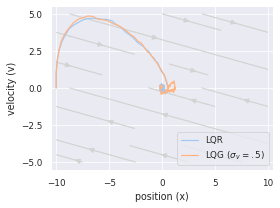

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.streamplot(xv, vv, qx, qv, density=.3, color='lightgrey')

ax.plot(X_lqr[:,0], X_lqr[:,1], label='LQR')
ax.plot(X_lqg[:,0], X_lqg[:,1], label=r'LQG ($\sigma_v=.5$)')

ax.set_xlim([-10.5, 10.5])
ax.set_ylim([-5.5, 5.5])
ax.set_xticks(np.linspace(-10, 10, 5))
ax.set_yticks(np.linspace(-5, 5, 5))

ax.set_xlabel('position (x)')
ax.set_ylabel('velocity (v)')

ax.legend()

plt.tight_layout()

figurename = f'figures/LQR_linear.png'
plt.savefig(figurename, dpi=300)

plt.show()

### Orbital

In [13]:
threshold = 1.5
x0 = jnp.array([(5/6)*np.pi, 4])

env = Orbital_SDI(dt=dt, end_time=T)
env.v = jnp.zeros((env.dim, env.dim))
controller = LQRSolver(env.A, env.B, env.G, env.R)

X_lqr, Y, U, R = run_LQR(env, controller, T=T, dt=dt, x0=x0)
idx_tmp = np.where(X_lqr[:,0] > np.pi/2)[0]
X_lqr[idx_tmp] += -2*np.pi

env.v = jnp.identity(env.dim) * .5
controller = LQGSolver(env.A, env.B, env.C, env.w, env.v, env.G, jnp.identity(env.dim), None)

X_lqg, _, _, _ = run_LQG(env, controller, T=T, dt=dt, x0=x0)
idx_tmp = np.where(X_lqg[:,0] > np.pi/2)[0]
X_lqg[idx_tmp] += -2*np.pi


In [14]:
env.v = jnp.identity(env.dim) * 0

N = 10

x_space = np.linspace(-(3/2)*np.pi, (1/2)*np.pi, N)
v_space = np.linspace(-5, 5, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

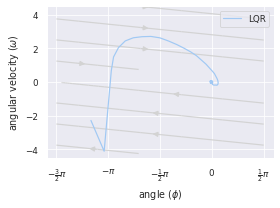

In [15]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.streamplot(xv, vv, qx, qv, density=.3, color='lightgrey')

ax.plot(X_lqr[:,0], X_lqr[:,1], label='LQR')
#ax.plot(X_lqg[:,0], X_lqg[:,1], label=r'LQG $\sigma_v = .5$')

ax.set_xlim([-(3/2)*np.pi-.3, (1/2)*np.pi+.3])
ax.set_ylim([-4.5, 4.5])
ax.set_xticks(np.linspace(-(3/2)*np.pi, (1/2)*np.pi, 5), [r'$-\frac{3}{2}\pi$', r'$-\pi$', r'$-\frac{1}{2}\pi$', r'$0$', r'$\frac{1}{2}\pi$'])
ax.set_yticks(np.linspace(-4, 4, 5))

ax.set_xlabel(r'angle ($\phi$)')
ax.set_ylabel(r'angular velocity ($\omega$)')

ax.legend()

plt.tight_layout()

figurename = f'figures/LQR_orbital.png'
plt.savefig(figurename, dpi=300)

plt.show()

### Box-constrained

In [9]:
x0 = jnp.array([-4, -4])

env = Box_SDI(dt=dt, end_time=T)
env.v = jnp.identity(env.dim) * 0
controller = LQRSolver(env.A, env.B, env.G, env.R)

X_lqr, Y, U, R = run_LQR(env, controller, T=T, dt=dt, x0=x0)
idx_tmp = np.where(abs(np.diff(X_lqr[:,1])) > threshold)[0] + 1
X_lqr[idx_tmp] = np.nan

env.v = jnp.identity(env.dim) * .5
controller = LQGSolver(env.A, env.B, env.C, env.w, env.v, env.G, jnp.identity(env.dim), None)

X_lqg, _, _, _ = run_LQG(env, controller, T=T, dt=dt, x0=x0)

In [10]:
env.v = jnp.identity(env.dim) * 0

N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-5, 5, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

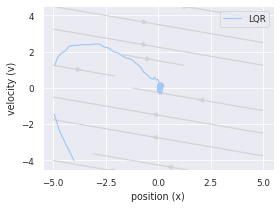

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.streamplot(xv, vv, qx, qv, density=.3, color='lightgrey')

ax.plot(X_lqr[:,0], X_lqr[:,1], label='LQR')
#ax.plot(X_lqg[:,0], X_lqg[:,1], label=r'LQG ($\sigma_v=.5$)')

ax.set_xlim([-5.5, 5.5])
ax.set_ylim([-4.5, 4.5])
ax.set_xticks(np.linspace(-5, 5, 5))
ax.set_yticks(np.linspace(-4, 4, 5))

ax.set_xlabel('position (x)')
ax.set_ylabel('velocity (v)')

ax.legend()

plt.tight_layout()

figurename = f'figures/LQR_box.png'
plt.savefig(figurename, dpi=300)

plt.show()